## Notebook on stitching experiment on Conv autoencoders trained on MNIST

### Imports and settings

In [ ]:
import logging
import numpy as np 

import pandas as pd
import torch
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


import matplotlib.pyplot as plt

logging.getLogger().setLevel(logging.ERROR)

DEVICE: str = "cuda"

err


### functional map 


In [9]:
from estimators.FM import FM_T
from utils.fmap import build_graph


In [10]:
def compute_graph(embeddings,num_eigs=50):
    G = build_graph(embeddings,  algo="knn", kernel="distance", similarity="angular",k=300)
    print(f"Is connected? {G.G.isconnected()}")
            # compute eigenvalues and eigenvectors
    G.eigvals,G.eigvecs =G.eigen_decomp(k=num_eigs)
    return G

In [11]:
class ConvAutoencoder(nn.Module):
    def __init__(self,channels=1,dim=256):
        super(ConvAutoencoder, self).__init__()
        inn_size=7 if channels==1 else 8
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1), # [b, 32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # [b, 64, 7, 7]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * inn_size * inn_size, dim)  # Latent space
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(dim, 64 * inn_size * inn_size),
            nn.ReLU(),
            nn.Unflatten(1, (64, inn_size, inn_size)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # [b, 32, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(32, channels, kernel_size=3, stride=2, padding=1, output_padding=1), # [b, 1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [12]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from pytorch_lightning.utilities.seed import seed_everything
from tqdm import tqdm


seeds=[42,123]

test_embeddings=dict()
for seed in seeds:
    seed_everything(seed)

    # Define the data transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load the MNIST dataset
    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

    # Define the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

    # Define the autoencoder model

    # Initialize the autoencoder model
    model = ConvAutoencoder()

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.to(DEVICE)
    # Train the autoencoder
    num_epochs = 1
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for data in train_loader:
            images, _ = data
            x=images.to(DEVICE)
            optimizer.zero_grad()
            encoded, decoded = model(x)
            loss = criterion(decoded, x.detach())
            loss.backward()
            optimizer.step()
    
        # Calculate the reconstruction loss on the test set
        test_loss = 0.0
        num_samples = 0

        model.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            for data in test_loader:
                images, _ = data
                x = images.to(DEVICE)
                encoded, decoded = model(x)
                loss = criterion(decoded, x.detach())
                test_loss += loss.item() * x.size(0)
                num_samples += x.size(0)

        test_loss /= num_samples

        print(f"Reconstruction loss on the test set: {test_loss:.4f}")
    

    # Save the test embeddings
    os.makedirs('checkpoints_mnist_MNIST', exist_ok=True)
    with torch.no_grad():
        for batch_id,data in enumerate(test_loader):
            images, _ = data
            x = images.to(DEVICE)
            encoded, decoded = model(x)
            if batch_id==0:
                test_embeddings['seed'+str(seed)]=encoded.detach().cpu().numpy()
            else:
                test_embeddings['seed'+str(seed)]=np.concatenate((test_embeddings['seed'+str(seed)],encoded.detach().cpu().numpy()),axis=0)
    np.save(f'checkpoints_mnist_MNIST/test_embeddings_seed_{seed}.npy', test_embeddings['seed'+str(seed)])

    torch.save(model.state_dict(), f'checkpoints_mnist_MNIST/model_weights_seed{seed}.pth')
    


Global seed set to 42


100%|██████████| 1/1 [00:10<00:00, 10.68s/it]

Reconstruction loss on the test set: 0.4911



Global seed set to 123
100%|██████████| 1/1 [00:09<00:00,  9.33s/it]

Reconstruction loss on the test set: 0.4901


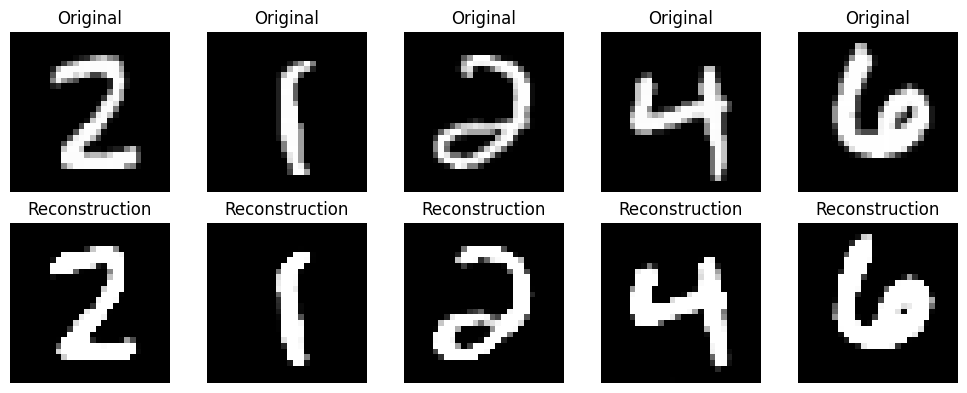

In [13]:
import random

# Set the seed for reproducibility
random.seed(42)

# Number of random reconstructions to plot
num_reconstructions = 5

# Select random samples from the test set
random_samples = random.sample(range(len(test_dataset)), num_reconstructions)

# Plot the random reconstructions
fig, axs = plt.subplots(2, num_reconstructions, figsize=(10, 4))

for i, sample_idx in enumerate(random_samples):
    # Get the image and its reconstruction
    image, _ = test_dataset[sample_idx]
    reconstruction = model(image.unsqueeze(0).to(DEVICE))[1].squeeze(0).detach().cpu()

    # Plot the original image
    axs[0,i].imshow(image.squeeze(), cmap='gray')
    axs[0,i].axis('off')
    axs[0,i].set_title('Original')

    # Plot the reconstruction
    axs[1,i].imshow(reconstruction.squeeze(), cmap='gray')
    axs[1,i].axis('off')
    axs[1,i].set_title('Reconstruction')

plt.tight_layout()
plt.show()




In [14]:
#load the models
path_model1=f'checkpoints_mnist_MNIST/test_embeddings_seed_{seeds[0]}.npy'
path_model2=f'checkpoints_mnist_MNIST/test_embeddings_seed_{seeds[1]}.npy'



# Placeholder function for your custom functional map computation
def compute_functional_map(x, y,n_anchor=5):
    anchors=torch.stack([torch.arange(0,n_anchor),torch.arange(0,n_anchor)],1)
    fmap=FM_T(torch.from_numpy(x),torch.from_numpy(y),anchors,num_eigs=50,graph_algo='knn',graph_similarity='angular',graph_kernel='distance',descriptors=('dist_geod',),k=300,n_descr=10,compute_gt_map=False)
    return fmap



X = np.load(path_model1)

Y = np.load(path_model2)
n_anchor=5   

fmap=compute_functional_map(X,Y,n_anchor=n_anchor)
#torch.seed()
if type(X)!=torch.Tensor:
    X=torch.from_numpy(X).float()
    Y=torch.from_numpy(Y).float()

Y_hat=X@fmap.T.numpy()


anchors=torch.stack([torch.arange(0,n_anchor),torch.arange(0,n_anchor)])


T=torch.linalg.lstsq(X[anchors[0,:]],Y[anchors[0,:]]).solution
Y_hat_t=X@T.numpy()


path_model1=f'checkpoints_mnist_MNIST/model_weights_seed{seeds[0]}.pth'
path_model2=f'checkpoints_mnist_MNIST/model_weights_seed{seeds[1]}.pth'

m1=ConvAutoencoder()
m1.load_state_dict(torch.load(path_model1))

m2=ConvAutoencoder()
m2.load_state_dict(torch.load(path_model2))


/home/marco/anaconda3/envs/lady/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Is connected? True
Is connected? True
Computing functional map with descriptors:  ['dist_geod']


<All keys matched successfully>

In [15]:
import os 
savedir='Results_autoencoder_stitching'
os.makedirs(savedir,exist_ok=True)

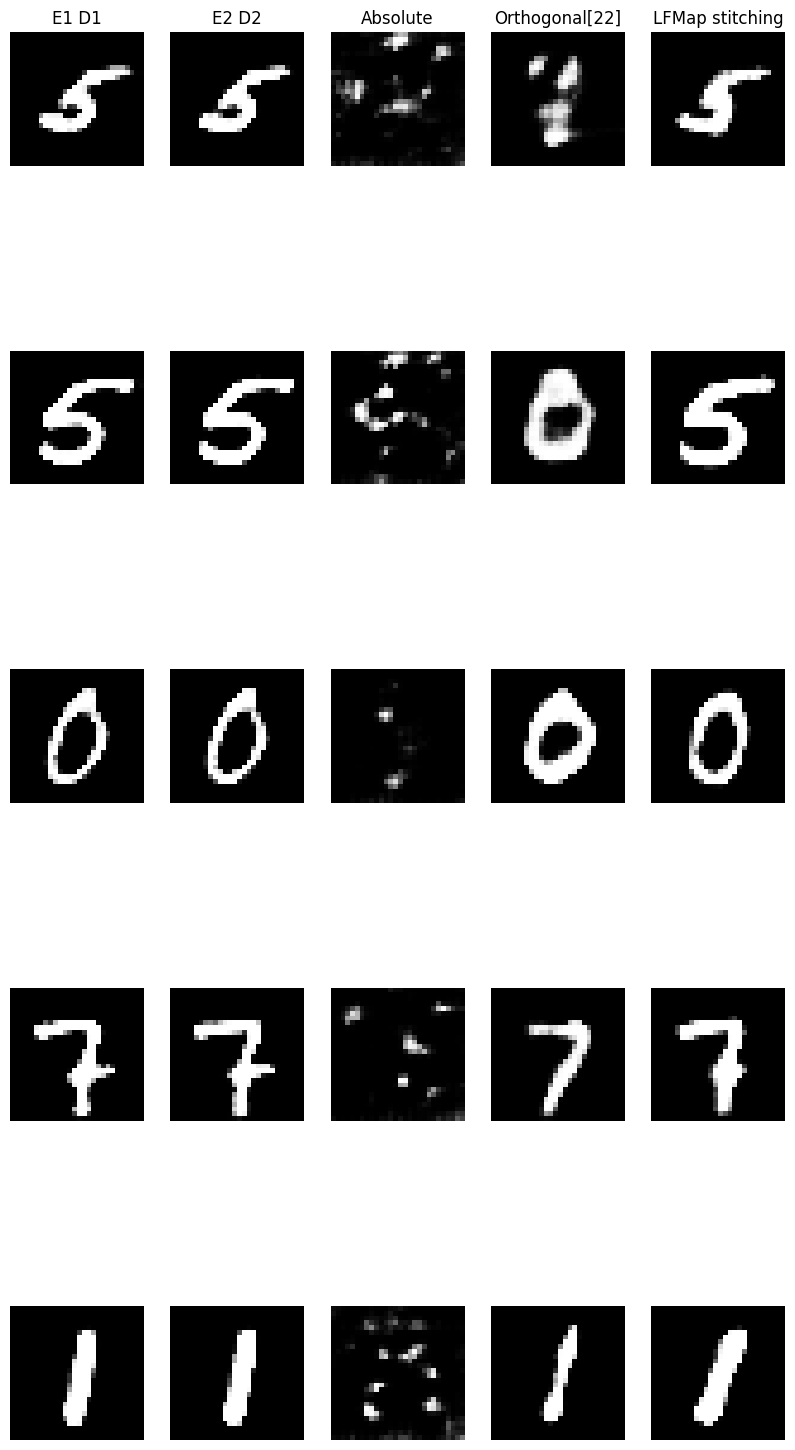

In [16]:
torch.manual_seed(42)

N=5
if type(X)!=torch.Tensor:
    X=torch.from_numpy(X).float()
    Y=torch.from_numpy(Y).float()
    Y_hat=torch.from_numpy(Y_hat).float()
idx=torch.randperm(X.shape[0])[:N]

out_X=m1.decoder(X[idx,:]).reshape(-1,28,28)
out_Y=m2.decoder(Y[idx,:]).reshape(-1,28,28)

out_X_hat=m2.decoder(Y_hat[idx,:]).reshape(-1,28,28)
out_XY=m2.decoder(X[idx,:]).reshape(-1,28,28)
out_X_HAT_T=m2.decoder(Y_hat_t[idx,:]).reshape(-1,28,28)
fig,axs=plt.subplots(N,5,figsize=(10,20))
for i in range(N):
    axs[i,0].imshow(out_X[i].detach().numpy(),cmap='gray')
    axs[i,1].imshow(out_Y[i].detach().numpy(),cmap='gray')
    axs[i,4].imshow(out_X_hat[i].detach().numpy(),cmap='gray')
    axs[i,2].imshow(out_XY[i].detach().numpy(),cmap='gray')
    axs[i,3].imshow(out_X_HAT_T[i].detach().numpy(),cmap='gray')
    axs[i,0].axis('off')
    axs[i,1].axis('off')
    axs[i,2].axis('off')
    axs[i,3].axis('off')
    axs[i,4].axis('off')

# Add column names
axs[0,0].set_title('E1 D1')
axs[0,1].set_title('E2 D2')
axs[0,4].set_title('LFMap stitching')
axs[0,2].set_title('Absolute')
axs[0,3].set_title('Orthogonal[22]')
plt.savefig(os.path.join(savedir,'mnist_autoencoder.png'),dpi=300)
plt.show()
